# Galaxy classifier
## Import libraries, path and labels dict
https://www.kaggle.com/addisonkendalllr/galaxydataset

In [2]:
import numpy as np 
import pandas as pd 

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pk
import pprint
import time

from PIL import Image
from skimage.io import imread
from skimage.transform import resize

from ipywidgets import IntProgress
from IPython.display import display
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

Train images must be in ~/image/label_x folder

In [3]:
img_files = np.array(glob("images/*"))
img_files

array(['images\\edge', 'images\\other', 'images\\smooth',
       'images\\spiral'], dtype='<U13')

In [4]:
# Create dict of breeds
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

## Image pre-processing

In [5]:
# Define image size to be transfered to the CNN
size = (128, 128)

In [6]:
# Load and resize image + store in array
def load_images(folder):
    images = []
    target = []
    for i in range(len(folder)):
        
        # print progress and number of files   
        num_file = len(os.listdir(folder[i]))
        print('label',str(i)+'/'+str(len(folder)-1)+' path:',folder[i], str(num_file)+" files")
        
        # Progress bar
        max_count = num_file
        f = IntProgress(min=0, max=max_count) # instantiate the bar
        display(f) # display the bar
        
        # load and resize images from a folder
        for filename in os.listdir(folder[i]):
            f.value += 1
            img = imread(os.path.join(folder[i], filename), as_gray=False)
            if img is not None:
                # resize image
                img = resize(img, size, mode='reflect')
                # convert to np array
                img = np.asarray(img)
                # append image list and target list
                images.append(img)
                target.append(i)       
                
    return images, target

In [8]:
# RUN ONLY IF PKL FILES ARE NOT AVAILABLE
cat_features, cat_targets = load_images(img_files)

label 0/3 path: images\edge 100 files


IntProgress(value=0)

label 1/3 path: images\other 100 files


IntProgress(value=0)

label 2/3 path: images\smooth 100 files


IntProgress(value=0)

label 3/3 path: images\spiral 100 files


IntProgress(value=0)

In [9]:
# dump features in a pickle file
with open("features.pkl", 'wb') as file:
    pk.dump(cat_features, file)

# dump labels in a pickle file
with open("labels.pkl", 'wb') as file:
    pk.dump(cat_targets, file)

image dimension: (128, 128, 3)


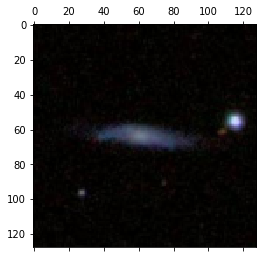

In [10]:
def display_example(images, id_img):
    # display image that the CNN will see
    plt.matshow(images[id_img]) 
    print('image dimension:',images[id_img].shape)
    
display_example(cat_features, 42)

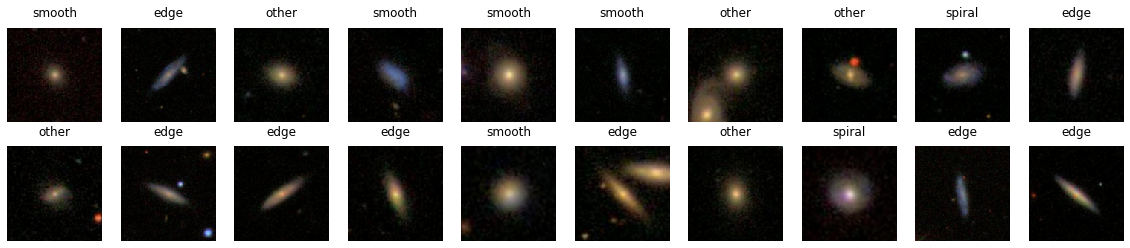

In [11]:
# Schuffle images
img_shuffle, _, lab_shuffle, _ = train_test_split(cat_features, cat_targets, shuffle = True)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.matshow(img_shuffle[idx], cmap='gray') 
    ax.set_title(target_dict[lab_shuffle[idx]])
    ax.axis('off')

## CNN

In [12]:
with open("features.pkl", 'rb') as fid:
    X = pk.load(fid)

with open("labels.pkl", 'rb') as fid:
    y = pk.load(fid)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle = True, test_size=0.2, random_state=None)

In [14]:
y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

In [15]:
X_train = np.asarray(X_train)
print('X_train shape:',X_train.shape)

y_train = np.asarray(y_train)
print('y_train shape:',y_train.shape)

X_test = np.asarray(X_test)
print('X_test shape:',X_test.shape)

y_test = np.asarray(y_test)
print('y_test shape:',y_test.shape)

X_train shape: (320, 128, 128, 3)
y_train shape: (320, 4)
X_test shape: (80, 128, 128, 3)
y_test shape: (80, 4)


In [17]:
model = Sequential()
# 64 3x3 kernels
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=X_train.shape[-3:]))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.5))
# Final categorization from 0-9 with softmax
model.add(Dense(y_train.shape[-1], activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32514176  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=2, validation_data=(X_test, y_test))

Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 - 39s - loss: 2.0808 - acc: 0.2812 - val_loss: 1.3707 - val_acc: 0.2500
Epoch 2/10
320/320 - 36s - loss: 1.3773 - acc: 0.2844 - val_loss: 1.3598 - val_acc: 0.2625
Epoch 3/10
320/320 - 36s - loss: 1.3118 - acc: 0.4719 - val_loss: 1.3220 - val_acc: 0.3000
Epoch 4/10
320/320 - 37s - loss: 1.2408 - acc: 0.4594 - val_loss: 1.2737 - val_acc: 0.3500
Epoch 5/10
320/320 - 35s - loss: 1.1985 - acc: 0.4781 - val_loss: 1.2210 - val_acc: 0.5250
Epoch 6/10
320/320 - 37s - loss: 1.0331 - acc: 0.5844 - val_loss: 1.1814 - val_acc: 0.5125
Epoch 7/10
320/320 - 35s - loss: 0.9346 - acc: 0.6687 - val_loss: 1.2210 - val_acc: 0.4250
Epoch 8/10
320/320 - 35s - loss: 0.8167 - acc: 0.7000 - val_loss: 1.1468 - val_acc: 0.5250
Epoch 9/10
320/320 - 37s - loss: 0.7698 - acc: 0.6969 - val_loss: 1.1010 - val_acc: 0.5125
Epoch 10/10
320/320 - 36s - loss: 0.7044 - acc: 0.7344 - val_loss: 1.0559 - val_acc: 0.5625


In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0558766841888427
Test accuracy: 0.5625


In [22]:
model.save('galaxy_cnn__model.h5')

## Test classifier

In [23]:
img_files = np.array(glob("images/*"))
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

In [25]:
trained_model = tensorflow.keras.models.load_model('galaxy_cnn__model.h5')

In [26]:
test_img_files = np.array(glob("test_files"))
test_img_files

array(['test_files'], dtype='<U10')

In [31]:
test_features, _ = load_images(test_img_files)

label 0/0 path: test_files 80 files


IntProgress(value=0, max=80)

In [32]:
test_features = np.asarray(test_features)
print('test_features shape:',test_features.shape)

test_features shape: (80, 128, 128, 3)


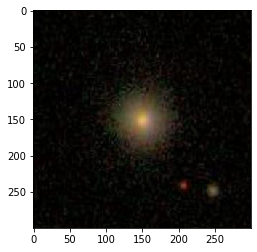

Predicted class: smooth


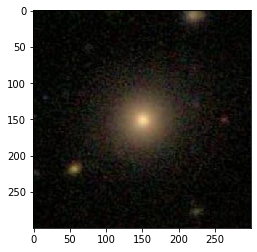

Predicted class: smooth


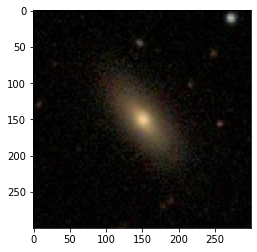

Predicted class: smooth


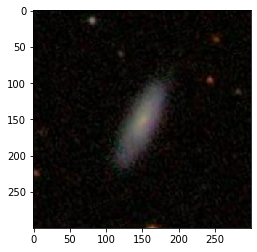

Predicted class: edge


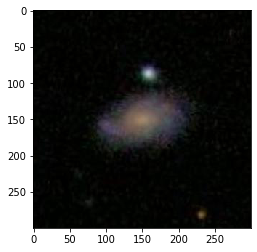

Predicted class: spiral


In [33]:
def print_class(features, idx):
    img = imread(os.path.join('test_files', os.listdir(test_img_files[0])[idx]), as_gray=False)
    plt.imshow(img)
    plt.show()
    # Results into dataframe
    result = trained_model.predict_classes(features[idx].reshape(1,128,128,3))
    return 'Predicted class: '+target_dict[result[0]]

# print i examples in the test images list
for i in np.random.choice(range(len(os.listdir(test_img_files[0]))-1), 5, replace=False):
    print(print_class(test_features, i))